#### データの全体像
train：1,482,535個のユーザーが投稿した商品

test：693,359行で「価格（Price）」の項目がテストデータは含まれていないため、列数は「7」となっている 

* train_id / test _id – ユーザー投稿のID
* name – 投稿のタイトル。タイトルに価格に関する情報がある場合（例：$20）はメルカリが事前に削除をして[rm]と置き換えている。
* item_condition_id – ユーザーが指定した商品の状態(1~5,大きい方が状態が良い)
* category_name – 投稿カテゴリー
* brand_name – ブランドの名前
* price – 訓練データのみ。実際に売られた価格。米ドル表示。今回のチャレンジの予測ターゲットとなる。
* shipping – 送料のフラグ。「1」は販売者負担。「0」は購入者負担。
* item_description – ユーザーが投稿した商品説明の全文。タイトルと同様に価格情報がある場合は[rm]と置き換えられている。

In [1]:
from datetime import datetime
start_real = datetime.now() # 全体の処理時間の計測を開始する

#### ライブラリのインポート

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import save_npz, load_npz

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import Ridge

import gc
import warnings
warnings.simplefilter("ignore")

#### データの読み込み

In [2]:
%%time
# Kaggle Notebook
train = pd.read_csv("/kaggle/input/mercari-dataset/train.tsv", delimiter='\t')
test = pd.read_csv("/kaggle/input/mercari-dataset/test.tsv", delimiter='\t')

# Local
# train = pd.read_csv("train.tsv", delimiter='\t')
# test = pd.read_csv("test.tsv", delimiter='\t')

CPU times: user 10.9 s, sys: 1.47 s, total: 12.4 s
Wall time: 17.3 s


In [3]:
print(train.shape)
print(train.info())
display(train.head())

(1482535, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [4]:
print(test.shape)
print(test.info())
display(test.head())

(693359, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693359 entries, 0 to 693358
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   test_id            693359 non-null  int64 
 1   name               693359 non-null  object
 2   item_condition_id  693359 non-null  int64 
 3   category_name      690301 non-null  object
 4   brand_name         397834 non-null  object
 5   shipping           693359 non-null  int64 
 6   item_description   693359 non-null  object
dtypes: int64(3), object(4)
memory usage: 37.0+ MB
None


,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


#### データの前処理

In [5]:
# 3ドル以上2000ドル以下のデータのみを使用する
train = train[(train["price"] >= 3) & (train["price"] <= 2000)]

#### price を対数変換

In [6]:
train['price'] = np.log1p(train['price'])

#### train, test を行方向に結合し、まとめて前処理できるようにする

In [7]:
# 列名を id に変更
train.rename(columns={'train_id': 'id'}, inplace=True)
test.rename(columns={'test_id': 'id'}, inplace=True)

# データフレームを結合
train_test_combine = pd.concat([train,test]) # axis=0 で行、axis=1 で列に結合 デフォルトは axis=0
print(train_test_combine.shape)
train_test_combine.head()

(2175017, 8)


,id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,2.397895,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3.970292,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,2.397895,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,3.583519,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,3.806662,0,Complete with certificate of authenticity


#### 欠損値処理


In [8]:
train.isnull().sum()

id                        0
name                      0
item_condition_id         0
category_name          6314
brand_name           632336
price                     0
shipping                  0
item_description          6
dtype: int64

In [9]:
train_test_combine.isnull().sum()

id                        0
name                      0
item_condition_id         0
category_name          9372
brand_name           927861
price                693359
shipping                  0
item_description          6
dtype: int64

In [10]:
# 母数217万点に対して category_name の1万点は少ないため、missing に置き換えず単純に drop
train_test_combine.dropna(subset=['category_name'], inplace=True)

In [11]:
# 欠損値を missing で埋める
# train_test_combine['category_name'].fillna(value='missing', inplace=True)
train_test_combine['brand_name'].fillna(value='missing', inplace=True)
train_test_combine['item_description'].fillna(value='missing', inplace=True)

In [12]:
%%time
brand_name_list = set(train_test_combine["brand_name"].values) # set()で重複を削除

def brandfinder(line):
    brand = line[0]
    name = line[1]
    namesplit = name.split(' ')
    
    if brand == 'missing':
        for x in namesplit:
            if x in brand_name_list:            
                return x # name(商品名全体)を返すのではなく、x(ブランド名)のみを返す
    if name in brand_name_list:
        return name
    
    return brand

# ブランド名の付替えを実施
train_test_combine['brand_name'] = train_test_combine[['brand_name','name']].apply(brandfinder, axis = 1) # axis=1で行方向

# brandfinderの中身
train_test_combine[['brand_name','name']].head(10)

CPU times: user 1min 48s, sys: 341 ms, total: 1min 48s
Wall time: 1min 48s


,brand_name,name
0,MLB,MLB Cincinnati Reds T Shirt Size XL
1,Razer,Razer BlackWidow Chroma Keyboard
2,Target,AVA-VIV Blouse
3,missing,Leather Horse Statues
4,missing,24K GOLD plated rose
5,missing,Bundled items requested for Ruie
6,Acacia Swimwear,Acacia pacific tides santorini top
7,Soffe,Girls cheer and tumbling bundle of 7
8,Nike,Girls Nike Pro shorts
9,missing,Porcelain clown doll checker pants VTG


#### category_name を3等分する

In [13]:
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label") # 欠損値は drop したため恐らく不要

train_test_combine['general_cat'] = train_test_combine['category_name'].apply(lambda x: split_cat(x)[0])
train_test_combine['sub_cat1'] = train_test_combine['category_name'].apply(lambda x: split_cat(x)[1])
train_test_combine['sub_cat2'] = train_test_combine['category_name'].apply(lambda x: split_cat(x)[2])
display(train_test_combine.head())

,id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,sub_cat2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,MLB,2.397895,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3.970292,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,2.397895,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,3.583519,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,3.806662,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [14]:
# ベクトル化（カウントやTF-IDF）およびエンコーディング（ONE-HOT）の前にメモリをクリアしておく
gc.collect()

4

#### 特徴エンコーディング｜CountVectorizer(), TfidfVectorizer()

In [15]:
%%time
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(train_test_combine['name'])

tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1,3), stop_words='english')
X_descp = tfidf.fit_transform(train_test_combine['item_description'])

print('name vectorization shape:', X_name.shape)
print('item_description vectorization shape:', X_descp.shape)

name vectorization shape: (2165645, 130463)
item_description vectorization shape: (2165645, 50000)
CPU times: user 6min 3s, sys: 9.66 s, total: 6min 13s
Wall time: 6min 12s


#### 特徴エンコーディング｜OneHotEncoder()

In [16]:
%%time
ohe = OneHotEncoder()

# OneHotEncoder は2次元の入力を必要とするため、.reshape(-1, 1) で1次元の Series を2次元に変換
X_brand_name = ohe.fit_transform(train_test_combine['brand_name'].values.reshape(-1, 1))
X_item_condition_id = ohe.fit_transform(train_test_combine['item_condition_id'].values.reshape(-1, 1))
X_shipping = ohe.fit_transform(train_test_combine['shipping'].values.reshape(-1, 1))
X_general_cat = ohe.fit_transform(train_test_combine['general_cat'].values.reshape(-1, 1))
X_sub_cat1 = ohe.fit_transform(train_test_combine['sub_cat1'].values.reshape(-1, 1))
X_sub_cat2 = ohe.fit_transform(train_test_combine['sub_cat2'].values.reshape(-1, 1))

CPU times: user 3.92 s, sys: 78.1 ms, total: 4 s
Wall time: 3.99 s


In [17]:
print('brand encoding shape:', X_brand_name.shape)
print('item condition id encoding shape:', X_item_condition_id.shape)
print('shipping encoding shape:', X_shipping.shape)
print('general_cat encoding shape:', X_general_cat.shape)
print('sub_cat1 encoding shape:', X_sub_cat1.shape)
print('sub_cat2 encoding shape:', X_sub_cat2.shape)

brand encoding shape: (2165645, 5265)
item condition id encoding shape: (2165645, 5)
shipping encoding shape: (2165645, 2)
general_cat encoding shape: (2165645, 10)
sub_cat1 encoding shape: (2165645, 113)
sub_cat2 encoding shape: (2165645, 882)


#### 生成されたスパース行列を結合

In [18]:
n_train = len(train) - 2721 # train から drop した分を引き算

combined_matrix_train = (X_name[:n_train], X_descp[:n_train], X_brand_name[:n_train], X_item_condition_id[:n_train], X_shipping[:n_train],
                   X_general_cat[:n_train], X_sub_cat1[:n_train], X_sub_cat2[:n_train])
X = hstack(combined_matrix_train).tocsr() # 説明変数

y = train['price'][:n_train] # 目的変数

combined_matrix_test = (X_name[n_train:], X_descp[n_train:], X_brand_name[n_train:], X_item_condition_id[n_train:], X_shipping[n_train:],
                   X_general_cat[n_train:], X_sub_cat1[n_train:], X_sub_cat2[n_train:])
test = hstack(combined_matrix_test).tocsr() # テストデータ

In [19]:
print(X.shape) # 説明変数
print(y.shape) # 目的変数
print(test.shape) # テストデータ

(1478937, 186740)
(1478937,)
(686708, 186740)


#### X と y の保存

In [21]:
# %%time
# save_npz('X.npz', X)
# y.to_csv('y.csv', index=False)

#### X と y の読み込み

In [22]:
# # Kaggle Notebook
# X = load_npz('/kaggle/input/mercari-preprocessed/X.npz')
# y = pd.read_csv('/kaggle/input/mercari-preprocessed/y.csv')

#### モデルの作成と学習

#### X と y のうち、7割を訓練用 (train)、3割を検証用 (test) に分割する

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [21]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1035255, 186740)
(1035255,)
(443682, 186740)
(443682,)


#### モデルの学習｜Ridge回帰

In [22]:
%%time
ridge = Ridge(solver="lsqr", fit_intercept=False, random_state=0)
ridge.fit(X_train, y_train)

CPU times: user 3min 12s, sys: 2min 7s, total: 5min 20s
Wall time: 1min 47s


Ridge(fit_intercept=False, random_state=0, solver='lsqr')

#### 訓練データに対する予測｜Ridge回帰

In [23]:
y_train_pred = ridge.predict(X_train)

In [24]:
y_min = np.append(y_train_pred, y_train).min()
y_max = np.append(y_train_pred, y_train).max()
y_margin = (y_max - y_min) * 0.1
y_min -= y_margin
y_max += y_margin

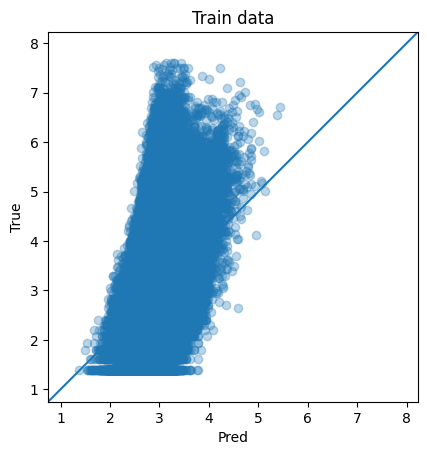

In [25]:
plt.scatter(y_train_pred, y_train, alpha=0.3)
plt.plot([y_min,y_max], [y_min,y_max])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(y_min, y_max)
plt.ylim(y_min, y_max)
plt.title('Train data')
plt.xlabel('Pred')
plt.ylabel('True')
plt.show()

In [26]:
# RMSLE関数の定義
def rmsle(y_true, y_pred):  
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [27]:
# モデルの評価
ridge_train_rmsle = rmsle(np.expm1(y_train), np.expm1(y_train_pred))
print("RMSLE for train data:", ridge_train_rmsle)

RMSLE for train data: 0.7067732424964764


#### テストデータに対する予測｜Ridge回帰

In [28]:
y_test_pred = ridge.predict(X_test)

In [29]:
y_min = np.append(y_test_pred, y_test).min()
y_max = np.append(y_test_pred, y_test).max()
y_margin = (y_max - y_min) * 0.1
y_min -= y_margin
y_max += y_margin

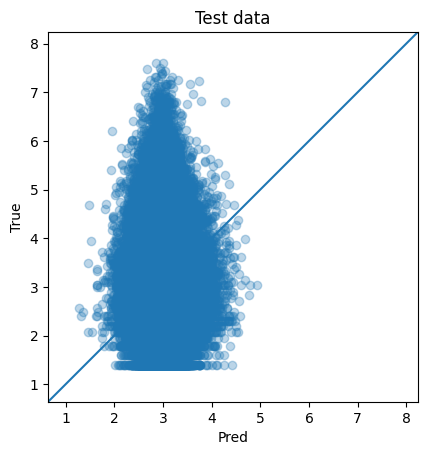

In [30]:
plt.scatter(y_test_pred, y_test, alpha=0.3)
plt.plot([y_min,y_max], [y_min,y_max])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(y_min, y_max)
plt.ylim(y_min, y_max)
plt.title('Test data')
plt.xlabel('Pred')
plt.ylabel('True')
plt.show()

In [31]:
# モデルの評価
ridge_test_rmsle = rmsle(np.expm1(y_test), np.expm1(y_test_pred))
print("RMSLE for test data:", ridge_test_rmsle)

RMSLE for test data: 0.7715181368464494


In [50]:
stop_real = datetime.now()
execution_time_real = stop_real - start_real
print(execution_time_real)

0:08:24.649593
